## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  
For this project, we will be working to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

Reading the dataset `ab_data.csv` and displaying the top five rows and exploring the data

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
# number of rows in the dataset.

#len(df.index)
df.shape[0]

294478

In [4]:
df.user_id.nunique() # The number of unique users in the dataset.

290584

In [5]:
#The proportion of users converted.

#len(df.query('converted==1'))/len(df.index)
#df.describe()

df['converted'].mean()

0.11965919355605512

In [6]:
# The number of times the new_page and treatment don't match.

'''
group1 = len(df.query('group!="treatment" and landing_page=="new_page"'))# number of times when group is not treatment but landing page is new page
group2 = len(df.query('group!="control" and landing_page=="old_page"'))# number of times when group is not control but landing page is old page
group=group1+group2
group

'''
df.query("(group == 'treatment' and landing_page != 'new_page') or (group != 'treatment' and landing_page == 'new_page') " ).shape[0]

3893

In [7]:
# Check if rows have missin value
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [ ]:
df.isnull().sum().all() # False

*No missing Values*

For the rows where treatment is not aligned with new_page or control is not aligned with old_page, we cannot be sure if this row truly received the new or old page.

Creating a new dataset that meets the folwing specifications and then store the new dataframe in **df2**.

In [9]:
df2 = df[((df.group=='treatment') & (df.landing_page=='new_page')) | ((df.group=='control') & (df.landing_page=='old_page'))]

In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [11]:
# Number of unique user_ids in df2.

df2.user_id.nunique()

290584

In [12]:
# There is user_id repeated in df2
df2.user_id[df2.user_id.duplicated()]

2893    773192
Name: user_id, dtype: int64

In [13]:
# The row information for the repeat user_id

#df2.loc[df2.user_id.duplicated()]

dup_data = df2['user_id'].duplicated()
# display duplicated data
df2[dup_data]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [2]:
# Remove one of the rows with a duplicate user_id.

df2.drop_duplicates(subset= "user_id",inplace= True)

In [15]:
# Check agin if duplicated values are deleted or not
df2['user_id'].duplicated().sum()

0

In [16]:
# Probability of an individual converting regardless of the page they receive

# df2[df2['converted'] == 1].user_id.nunique()/df2.user_id.nunique()

df2['converted'].mean() 

0.11959667567149027

In [17]:
# The probability of an individual converting given that an individual was in the control group
'''
control_group = len(df2.query('group=="control" and converted==1'))/len(df2.query('group=="control"'))
control_group
'''

df2[df2['group'] == 'control']['converted'].mean()

0.1203863045004612

In [18]:
# The probability of an individual converting given that an individual was in the treatment group
'''
treatment_group = len(df2.query('group=="treatment" and converted==1'))/len(df2.query('group=="treatment"'))
treatment_group
'''

df2[df2['group'] == 'treatment']['converted'].mean()

0.11880724790277405

In [19]:
# The probability of individual received new page

#len(df2.query('landing_page=="new_page"'))/df2.shape[0]

df2[df2.landing_page == 'new_page'].user_id.count()/df2.user_id.count()

0.5000636646764286

**According to our stats results, only 12% of viewers convert regardless of the type of page they receive. About 50% of individuals received the new page " there is a consistency among test subjects", and 12% of individuals in the `control` group converted. On the other side, about 12% of the individuals in the `treatment` group converted. So far there is not sufficient evidence to conclude that the new treatment page leads to more conversions. As the converting rate is similar in both cases so it is important to consider other factors.**

<a id='ab_test'></a>
### Part II - A/B Test



`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.



**In this case, there is a question associated with a direction - that is the new page is better than the old page, so we assume that this is the `Alternative hypothesis` and the `Null hypothesis` states that the old page is better than or same as the new page.**


$$H_0: \mu_{{old}} \geq \mu_{{new}} \implies\mu_{{new}} - \mu_{{old}} \leq 0$$


$$H_1: \mu_{{new}} > \mu_{{old}} \implies\mu_{{new}} - \mu_{{old}} > 0$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Q:
- Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

- Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

The **convert rate** for $p_{new}$ under the null. <br><br>

In [20]:
'''
The conversion rate of the new page, assuming that p_new = p_old 
under the null hypothesis.
'''
# p_new = len(df2.query( 'converted==1'))/len(df2.index)

p_new = df2.converted.mean()
p_new

0.11959667567149027

The **convert rate** for $p_{old}$ under the null. <br><br>

In [21]:
'''
The conversion rate of the old page, assuming that p_new = p_old 
under the null hypothesis.
'''
# p_old = len(df2.query('converted==1'))/len(df2.index)

p_old = df2.converted.mean()
p_old

0.11959667567149027

In [22]:
# probablity under null
p=np.mean([p_old,p_new])
p

0.11959667567149027

In [23]:
# difference of p_new and p_old
p_diff=p_new-p_old

#### Under null  p_old  is equal to  p_new

In [24]:
# The number of individuals in the treatment group

n_new = df2[df2['group'] == 'treatment'].shape[0]
n_new

145311

In [25]:
# The number of individuals in the control group

n_old = df2[df2['group'] == 'control'].shape[0]
n_old

145274

In [26]:
# Simulating n_new transactions with a convert rate of p_new under the null and store these n_new 1's and 0's in new_page_converted.

new_page_converted = np.random.choice([0, 1], n_new, p = [p_new, 1-p_new])

In [27]:
# Simulating n_old transactions with a convert rate of p_old under the null and store these n_old 1's and 0's in old_page_converted.

old_page_converted = np.random.choice([0, 1], n_old, p = [p_old, 1-p_old])

<br><br>
$p_{new}$ - $p_{old}$ for the simulated values.

In [28]:
# differences computed in from p_new and p_old
obs_diff= new_page_converted.mean() - old_page_converted.mean()
obs_diff

-0.0007335811399959979

Simulating 10,000 $p_{new}$ - $p_{old}$ values and store all 10,000 values in a numpy array  **p_diffs**.

In [29]:
# Create sampling distribution for difference in p_new-p_old simulated values
# with boostrapping
p_diffs = []
for _ in range(10000):
    np_converted = np.random.choice([0,1], n_new, p=[p_new, 1- p_new])
    op_converted = np.random.choice([0,1], n_old, p=[p_old, 1- p_old])
    p_diffs.append(np_converted.mean() - op_converted.mean())

Plotting a histogram of the p_diffs.

Text(0, 0.5, 'Count')

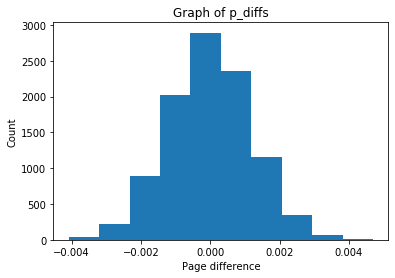

In [30]:
p_diffs=np.array(p_diffs)
#histogram of p_diff
plt.hist(p_diffs)
plt.title('Graph of p_diffs')#title of graphs
plt.xlabel('Page difference') # x-label of graphs
plt.ylabel('Count') # y-label of graphs

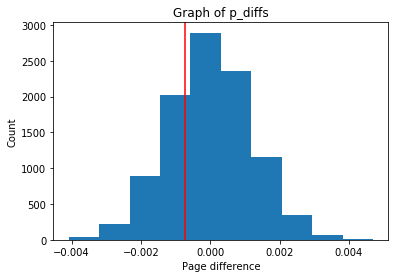

In [31]:
#histogram of p_diff
plt.hist(p_diffs);

plt.title('Graph of p_diffs') #title of graphs
plt.xlabel('Page difference') # x-label of graphs
plt.ylabel('Count') # y-label of graphs

plt.axvline(x= obs_diff, color='r');

In [32]:
# The actual difference between the proportion of individuals in the 
# treatment group and the proportion of individuals in the control group (obsorved mean difference)
act_diff = df2.query('group == "treatment"').converted.mean() - df2.query('group == "control"').converted.mean()

# The proportion of the p_diffs are greater than the actual difference act_diff
pval = (p_diff > act_diff).mean()
pval

0.9046


k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**The calculated value was p_value and since the p_value (0.9) is greater than alpha (0.05) we have evidence to fail to reject the null hypothesis. That is the changes in the old page don't affect the individual converting and the old page still better. it is not worth spending money and time to do this change.**

Using a built-in to achieve similar results (Alternative way). 

In [33]:
import statsmodels.api as sm

convert_old = df2.query(" landing_page == 'old_page' and converted == 1").shape[0] #rows converted with old_page
convert_new = df2.query(" landing_page == 'new_page' and converted == 1").shape[0] #rows converted with new_page
n_old = df2[df2['landing_page'] == 'old_page'].shape[0] #rows_associated with old_page
n_new = df2[df2['landing_page'] == 'new_page'].shape[0] #rows associated with new_page
n_new

145311

Using `stats.proportions_ztest` to compute our test statistic and p-value. 

In [34]:
# Smaller means that the alternative hypothesis is p_old < p_new
sig_alpha = .05
#Computing z_score and p_value
z_score, p_value = sm.stats.proportions_ztest([convert_old,convert_new], [n_old, n_new],alternative='smaller') 

#display z_score and p_value
print(z_score,p_value)

if p_value > sig_alpha:
   print ("Our evidence to fail to reject the null hypothesis, the new page is worse than the old page")
else:
   print ("Our evidence rejects the null hypothesis, and suggest the alternative hypothesis is true. The new page is better than the old page ")

1.3116075339133115 0.905173705140591


Our evidence to fail to reject the null hypothesis, the new page is worse than the old page

In [35]:
from scipy.stats import norm
norm.cdf(z_score) # How significant our z_score is

0.905173705140591

In [36]:
norm.ppf(1-(0.05)) #critical value of 95% confidence

1.6448536269514722

**z_score is less than critical value of 95% confidence. Hence we fail to reject null hypothesis. Therefore the conclusion is same as part j that we accept null hypothesis.**

<a id='regression'></a>
### Part III - A regression approach

In this final part, we will see that the result that acheived in the previous A/B test can also be acheived by performing regression.<br>

Since each row is either a conversion or no conversion, Logistic Regression should be performed in this case.

In [37]:
#adding an intercept column
df2['intercept'] = 1

#Create dummy variable column
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']

df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


Using statsmodels to import the regression model. <br>
Instantiating the model, and fit the model using the two columns we created before to predict whether or not an individual converts.

In [38]:
import statsmodels.api as sm
model=sm.Logit(df2['converted'],df2[['intercept','ab_page']])
results=model.fit() 

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [39]:
# Summary of the model.
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290583
Method:                           MLE   Df Model:                            1
Date:                Thu, 11 Jul 2019   Pseudo R-squ.:               8.085e-06
Time:                        17:32:46   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1897
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.312      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

The hypothesis in the **Part II** is:
$$H_0: \mu_{{new}} - \mu_{{old}} \leq 0$$


$$H_1: \mu_{{new}} - \mu_{{old}} > 0$$


The hypothesis in the**Logistic Regression** is:


$$H_0: \mu_{{new}} - \mu_{{old}} = 0$$


$$H_1: \mu_{{new}} - \mu_{{old }}  != 0$$


$H_0:$ There is no association between the old and new pages (the odds ratio is equal to 1).<br>
$H_1:$ There is an association between old and new pages (the odds ratio is not equal to 1).



The p-value associated with **ab_page is** 0.190.<br>
The finding shows that the p_value is greater than 0.05. it indicates that there is no significant association between the variable "converted" and the independent variable "ab_page", i.e there is no correlation between them, therefore the changes in the independent variable don't effect on the dependent variable. <br>
In other words, we have a sufficent evidence to fail to reject the Null hypothesis.

**Additional factors should be added into the regression models they may also influence the conversions also.**
**The disadvantage is that we don't know that our additional factor will influence the result in which direction.**
**As our additional factor changes every time on the basis of an additional factor.**

Now along with testing if the conversion rate changes for different pages, we're adding an effect based on which country a user lives, using `countries.csv` dataset and merging it with our datasets in the approporiate rows. 

In [4]:
# Store Countries.csv data in dataframe
countries = pd.read_csv('countries.csv')
countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [5]:
countries['country'].value_counts()

country
US    203619
UK     72466
CA     14499
Name: count, dtype: int64

In [52]:
#Inner join two datas
new = countries.set_index('user_id').join(df2.set_index('user_id'), how = 'inner')
new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
630000,US,2017-01-19 06:26:06.548941,treatment,new_page,0,1,1
630001,US,2017-01-16 03:16:42.560309,treatment,new_page,1,1,1
630002,US,2017-01-19 19:20:56.438330,control,old_page,0,1,0
630003,US,2017-01-12 10:09:31.510471,treatment,new_page,0,1,1
630004,US,2017-01-18 20:23:58.824994,treatment,new_page,0,1,1


In [53]:
#adding dummy variables with 'CA' as the baseline
new[['US', 'UK']] = pd.get_dummies(new['country'])[['US', "UK"]]
new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,US,UK
user_id,,,,,,,,,
630000,US,2017-01-19 06:26:06.548941,treatment,new_page,0,1,1,1,0
630001,US,2017-01-16 03:16:42.560309,treatment,new_page,1,1,1,1,0
630002,US,2017-01-19 19:20:56.438330,control,old_page,0,1,0,1,0
630003,US,2017-01-12 10:09:31.510471,treatment,new_page,0,1,1,1,0
630004,US,2017-01-18 20:23:58.824994,treatment,new_page,0,1,1,1,0


In [54]:
new['US_ab_page'] = new['US']*new['ab_page']
new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,US,UK,US_ab_page
user_id,,,,,,,,,,
630000,US,2017-01-19 06:26:06.548941,treatment,new_page,0,1,1,1,0,1
630001,US,2017-01-16 03:16:42.560309,treatment,new_page,1,1,1,1,0,1
630002,US,2017-01-19 19:20:56.438330,control,old_page,0,1,0,1,0,0
630003,US,2017-01-12 10:09:31.510471,treatment,new_page,0,1,1,1,0,1
630004,US,2017-01-18 20:23:58.824994,treatment,new_page,0,1,1,1,0,1


In [55]:
new['UK_ab_page'] = new['UK']*new['ab_page']
new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,US,UK,US_ab_page,UK_ab_page
user_id,,,,,,,,,,,
630000,US,2017-01-19 06:26:06.548941,treatment,new_page,0,1,1,1,0,1,0
630001,US,2017-01-16 03:16:42.560309,treatment,new_page,1,1,1,1,0,1,0
630002,US,2017-01-19 19:20:56.438330,control,old_page,0,1,0,1,0,0,0
630003,US,2017-01-12 10:09:31.510471,treatment,new_page,0,1,1,1,0,1,0
630004,US,2017-01-18 20:23:58.824994,treatment,new_page,0,1,1,1,0,1,0


In [56]:
logit3 = sm.Logit(new['converted'], new[['intercept', 'ab_page', 'US', 'UK', 'US_ab_page', 'US_ab_page']])
logit3

In [57]:
#Check the result
result3 = logit3.fit()

Optimization terminated successfully.
         Current function value: 0.366111
         Iterations 6


In [58]:
# Summary of the model.

result3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            4
Date:                Thu, 11 Jul 2019   Pseudo R-squ.:               2.590e-05
Time:                        17:37:16   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.2388
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0366      0.028    -72.618      0.000      -2.092      -1.982
ab_page       -0.0018      0.021     -0.086      0.931      -0.043       0.039
US             0.0501      0.030      1.691      0.091      -0.008       0.108
UK             0.0507      0.028      1.786      0.074      -0.005       0.106
US_ab_page    -0.0094   2.37e+06  -3.96e-09      1.000   -4.64e+06    4.64e+06
US_ab_page    -0.0094   2.37e+06  -3.96e-09      1.000   -4.64e+06    4.64e+06
==============================================================================
"""

## conclusion

The p_values, associated with the coefficients of both ab_page_UK and ab_page_US, are greater than 0.05 and they indicate that those factors don't have an impact on the response variable.

In conclusion, the p_values associated with the coefficients of all  explanatory variables in the logistic regression example are sufficent evidence that there is no corelation between the explanatory and response variables.

In the larger picture, based on the available information, we do not have sufficient evidence to suggest that the new page results in more conversions than the old page.

Finally, the p_values in PartII and partIII gave us a  sufficent evidence that we failed to reject the Null hypoth, Thus the new page has no effect on the individual converting.
